### Libraries

In [1]:
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from IPython.display import Image

import shap
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from yellowbrick.model_selection import FeatureImportances

from imblearn.over_sampling import SMOTE, ADASYN


import joblib
import pickle
import xgboost as xgb
from plot_learning import *
from sklearn.svm import SVC
from sklearn_rvm import EMRVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


warnings.filterwarnings('ignore')

c:\Anaconda\envs\artigo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn
sklearn.__version__

'1.1.2'

### Read 

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

X_train = pd.read_csv("X_train.csv", sep = ";")
X_test = pd.read_csv("X_test.csv", sep = ";")

y_train = pd.read_csv("y_train.csv", sep = ";")
y_test = pd.read_csv("y_test.csv", sep = ";")

X_train.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO
0,63,34,27,10.3,8.3,48.7,11.5,1.19,0.46,0.52
1,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40
2,66,34,29,11.4,5.8,49.4,11.1,0.87,0.25,0.23
3,101,77,46,10.9,13.3,52.2,17.3,1.48,0.27,1.07
4,83,46,19,8.5,10.3,49.3,14.9,1.05,0.39,0.39


In [4]:
X_train.columns

Index(['RFV', 'H1RFV', 'H2RFV', 'CONICITY', 'H1LFV', 'PLY', 'LFV', 'RRO',
       'CAPSPLICE', 'H1RRO'],
      dtype='object')

In [5]:
y_train.GR.unique()

array(['B', 'A', 'C'], dtype=object)

In [6]:
y_train.GR.value_counts()

B    35
A    34
C    11
Name: GR, dtype: int64

In [7]:
## removendo variáveis 
X_train = X_train.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

X_test = X_test.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

## Dataprep

In [8]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

In [9]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [10]:
print(Counter(y_train_enc).keys())
print(Counter(y_train_enc).values())

dict_keys([1, 0, 2])
dict_values([35, 34, 11])


In [11]:
print(Counter(y_test_enc).keys())
print(Counter(y_test_enc).values())

dict_keys([1, 0, 2])
dict_values([11, 12, 4])


In [12]:
minmax = MinMaxScaler()#StandardScaler() 


X_train = minmax.fit_transform(X_train)

# X_resampled = minmax.fit_transform(X_resampled)

# X_resampled = minmax.transform(X_resampled)
X_test = minmax.transform(X_test)

In [13]:
smote = SMOTE(k_neighbors=4, random_state=2310)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_enc)

In [14]:
print(Counter(y_resampled).keys())
print(Counter(y_resampled).values())

dict_keys([1, 0, 2])
dict_values([35, 35, 35])


In [15]:
pickle.dump(minmax, open( "./models/minmax.pickle", "wb" ))
pickle.dump(smote, open( "./models/smote.pickle", "wb" ))

## Model

In [16]:
def fit_and_print(model, X_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_enc, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test_enc, y_pred))  

    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test = lb.transform(y_test_enc)
    y_pred = lb.transform(y_pred)


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [17]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 64, 64)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Iterations")
    plt.ylabel("Score")

    train_scores_mean = df.mean_train_score
    train_scores_std = df.std_train_score
    test_scores_mean = df.mean_test_score
    test_scores_std = df.std_test_score
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Random Forest 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [18]:
RF = RandomForestClassifier(random_state = 23)
cv = LeaveOneOut()
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

RF_search_space = {"bootstrap": Categorical([True]), # values for boostrap can be either True or False
        "criterion": Categorical(["gini", "entropy"]),
        "max_depth": Integer(4, 8, prior='uniform'),
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10, prior='uniform'),
        "min_samples_split": Integer(8, 30, prior='uniform'),
        "n_estimators": Integer(5, 30, prior='uniform')
    }

In [19]:
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

RF_bayes_search = BayesSearchCV(RF, RF_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 100, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
RF_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(RF_bayes_search.best_score_)
RF_best = RF_bayes_search.best_estimator_
print(RF_bayes_search.best_estimator_)
print(RF_bayes_search.best_params_)

time train
243.29119753837585
Acc
0.9428571428571428
RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=23, random_state=23)
OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 8), ('n_estimators', 23)])


In [20]:
results = pd.DataFrame(RF_bayes_search.cv_results_).sort_values(by = 'rank_test_score')
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,split80_test_score,split81_test_score,split82_test_score,split83_test_score,split84_test_score,split85_test_score,split86_test_score,split87_test_score,split88_test_score,split89_test_score,split90_test_score,split91_test_score,split92_test_score,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,split100_test_score,split101_test_score,split102_test_score,split103_test_score,split104_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,split30_train_score,split31_train_score,split32_train_score,split33_train_score,split34_train_score,split35_train_score,split36_train_score,split37_train_score,split38_train_score,split39_train_score,split40_train_score,split41_train_score,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,split50_train_score,split51_train_score,split52_train_score,split53_train_score,split54_train_score,split55_train_score,split56_train_score,split57_train_score,split58_train_score,split59_train_score,split60_train_score,split61_train_score,split62_train_score,split63_train_score,split64_train_score,split65_train_score,split66_train_score,split67_train_score,split68_train_score,split69_train_score,split70_train_score,split71_train_score,split72_train_score,split73_train_score,split74_train_score,split75_train_score,split76_train_score,split77_train_score,split78_train_score,split79_train_score,split80_train_score,split81_train_score,split82_train_score,split83_train_score,split84_train_score,split85_train_score,split86_train_score,split87_train_score,split88_train_

<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

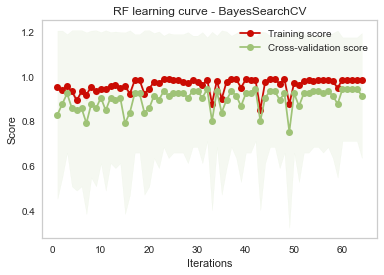

In [21]:
results_cv2 = pd.DataFrame(RF_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "RF learning curve - BayesSearchCV")
# results_cv2.head()

In [22]:
results.shape

(64, 228)

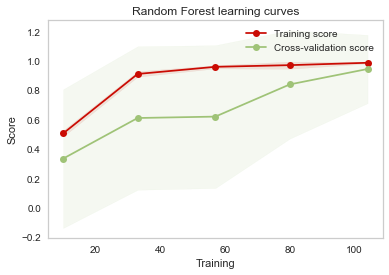

In [23]:
g = plot_learning_curve(RF_best,"Random Forest learning curves",X_resampled, y_resampled,cv=cv)

In [25]:
filename_vot = './models/RF_best_bayes_resampled.sav'
joblib.dump(RF_best, filename_vot)

['./models/RF_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.90      0.82      0.86        11
           2       0.60      0.75      0.67         4

    accuracy                           0.89        27
   macro avg       0.83      0.86      0.84        27
weighted avg       0.90      0.89      0.89        27

Gini:  [1.         0.75568182 0.66304348]
ROC AUC::  [1.         0.87784091 0.83152174]


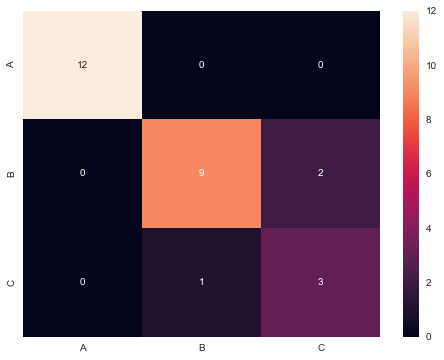

In [24]:
fit_and_print(RF_best, X_test)

### Support Vector Machine

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [26]:
SVM = SVC(random_state = 241)
cv = LeaveOneOut()

SVM_search_space = {
        'gamma': Real(0.01, 10, prior='uniform'), 
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']), 
        'C': Real(0.1, 10, prior='uniform')
    }


In [27]:
SVM_bayes_search = BayesSearchCV(SVM, SVM_search_space, n_iter=64, return_train_score = True,# specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 101, optimizer_kwargs = {'base_estimator': 'GP'} )

inicio = time.time()
SVM_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(SVM_bayes_search.best_score_)
SVM_best = SVM_bayes_search.best_estimator_
print(SVM_bayes_search.best_estimator_)
print(SVM_bayes_search.best_params_)

time train
122.70347714424133
Acc
0.9523809523809523
SVC(C=10.0, gamma=3.93015562844819, random_state=241)
OrderedDict([('C', 10.0), ('gamma', 3.93015562844819), ('kernel', 'rbf')])


In [22]:
# SVM_bayes_search.optimizer_results_

In [28]:
results = pd.DataFrame(SVM_bayes_search.cv_results_).sort_values(by = 'rank_test_score')
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,split80_test_score,split81_test_score,split82_test_score,split83_test_score,split84_test_score,split85_test_score,split86_test_score,split87_test_score,split88_test_score,split89_test_score,split90_test_score,split91_test_score,split92_test_score,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,split100_test_score,split101_test_score,split102_test_score,split103_test_score,split104_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,split30_train_score,split31_train_score,split32_train_score,split33_train_score,split34_train_score,split35_train_score,split36_train_score,split37_train_score,split38_train_score,split39_train_score,split40_train_score,split41_train_score,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,split50_train_score,split51_train_score,split52_train_score,split53_train_score,split54_train_score,split55_train_score,split56_train_score,split57_train_score,split58_train_score,split59_train_score,split60_train_score,split61_train_score,split62_train_score,split63_train_score,split64_train_score,split65_train_score,split66_train_score,split67_train_score,split68_train_score,split69_train_score,split70_train_score,split71_train_score,split72_train_score,split73_train_score,split74_train_score,split75_train_score,split76_train_score,split77_train_score,split78_train_score,split79_train_score,split80_train_score,split81_train_score,split82_train_score,split83_train_score,split84_train_score,split85_train_score,split86_train_score,split87_train_score,split88_train_score,split89_train_score,split90_train_score,split91_train_score,split92_train_score,split93_train_

<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

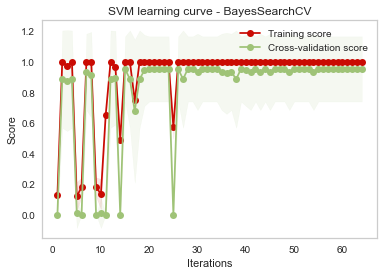

In [29]:
results_cv2 = pd.DataFrame(SVM_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "SVM learning curve - BayesSearchCV")

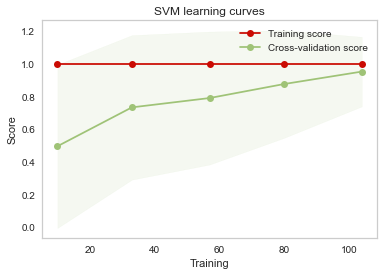

In [30]:
g = plot_learning_curve(SVM_best,"SVM learning curves",X_resampled,y_resampled,cv=cv)

In [31]:
filename_vot = './models/SVM_best_bayes_resampled.sav'
joblib.dump(SVM_best, filename_vot)

['./models/SVM_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.73      0.73      0.73        11
           2       0.40      0.50      0.44         4

    accuracy                           0.78        27
   macro avg       0.71      0.71      0.71        27
weighted avg       0.80      0.78      0.79        27

Gini:  [0.91666667 0.53977273 0.36956522]
ROC AUC::  [0.95833333 0.76988636 0.68478261]


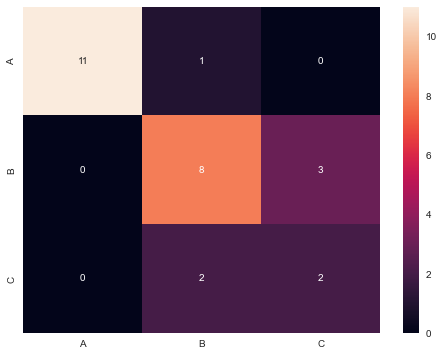

In [32]:
fit_and_print(SVM_best, X_test)

### Logistic Regression 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [89]:
LR = LogisticRegression(random_state=25)
cv = LeaveOneOut()

LR_search_space = {
    'solver': Categorical(['saga']),  
    'penalty': Categorical(['l1','l2']),
    'tol': Real(1e-5, 1e-3, 'uniform'),
    'C': Real(1e-5, 100, 'uniform'),
    'fit_intercept': Categorical([True, False])
}

In [90]:
LR_bayes_search = BayesSearchCV(LR, LR_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 102, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
LR_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(LR_bayes_search.best_score_)
LR_best = LR_bayes_search.best_estimator_
print(LR_bayes_search.best_estimator_)
print(LR_bayes_search.best_params_)

time train
133.61006999015808
Acc
0.8285714285714286
LogisticRegression(C=24.817163884261877, penalty='l1', random_state=25,
                   solver='saga', tol=0.0009832572491194637)
OrderedDict([('C', 24.817163884261877), ('fit_intercept', True), ('penalty', 'l1'), ('solver', 'saga'), ('tol', 0.0009832572491194637)])


<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

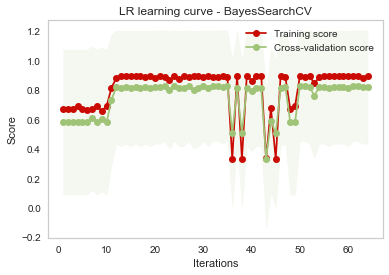

In [91]:
results_cv2 = pd.DataFrame(LR_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "LR learning curve - BayesSearchCV")

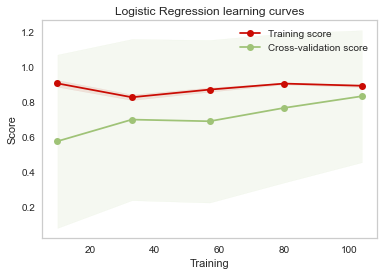

In [92]:
g = plot_learning_curve(LR_best,"Logistic Regression learning curves",X_resampled, y_resampled,cv=cv)

In [93]:
filename_vot = './models/LR_best_bayes_resampled.sav'
joblib.dump(LR_best, filename_vot)

['./models/LR_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.75      0.82      0.78        11
           2       0.67      0.50      0.57         4

    accuracy                           0.81        27
   macro avg       0.78      0.74      0.76        27
weighted avg       0.81      0.81      0.81        27

Gini:  [0.85       0.63068182 0.45652174]
ROC AUC::  [0.925      0.81534091 0.72826087]


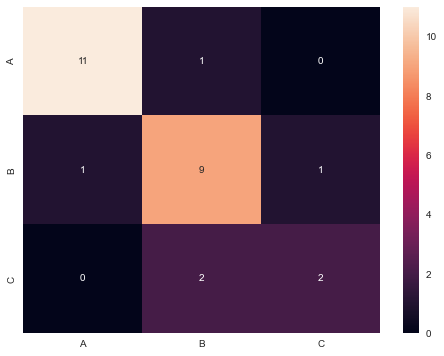

In [94]:
fit_and_print(LR_best, X_test)

### Multi-layer Perceptron

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [39]:
MLP = MLPClassifier(random_state = 26)
cv = LeaveOneOut()
MLP_search_space = {
    # 'hidden_layer_sizes': [(100,), (60,70,50), (70,80,60)],
    'activation':  Categorical(['tanh', 'relu', 'logistic', 'identity']),
    'solver':  Categorical(['sgd', 'adam']),
    'alpha': Real(0.0001, 0.5, prior='uniform'),
    'learning_rate': Categorical(['adaptive', 'constant', 'invscaling']),
    'learning_rate_init': Real(0.0001, 0.6, prior='uniform')
}

In [40]:
# MLP_model = RandomizedSearchCV(estimator= MLP, param_distributions = MLP_search_space, cv=cv, scoring="accuracy")
MLP_bayes_search = BayesSearchCV(MLP, MLP_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 102, optimizer_kwargs = {'base_estimator': 'GP'})

warnings.filterwarnings('ignore')
inicio = time.time()
MLP_bayes_search.fit(X_resampled, y_resampled)
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(MLP_bayes_search.best_score_)
MLP_best = MLP_bayes_search.best_estimator_
print(MLP_bayes_search.best_estimator_)
print(MLP_bayes_search.best_params_)

time train
435.47315859794617
Acc
0.9619047619047619
MLPClassifier(learning_rate='invscaling',
              learning_rate_init=0.10251567857105189, random_state=26)
OrderedDict([('activation', 'relu'), ('alpha', 0.0001), ('learning_rate', 'invscaling'), ('learning_rate_init', 0.10251567857105189), ('solver', 'adam')])


<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

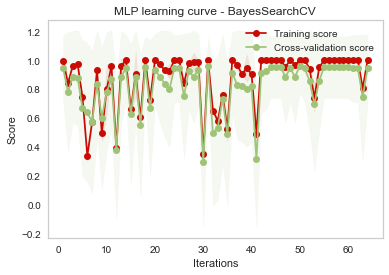

In [42]:
results_cv2 = pd.DataFrame(MLP_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "MLP learning curve - BayesSearchCV")

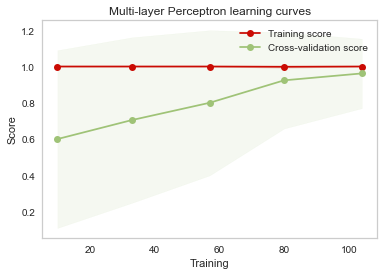

In [43]:
g = plot_learning_curve(MLP_best,"Multi-layer Perceptron learning curves", X_resampled, y_resampled,cv=cv)

In [44]:
filename_vot = './models/MLP_best_resampled.sav'
joblib.dump(MLP_best, filename_vot)

['./models/MLP_best_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.75      0.82      0.78        11
           2       1.00      0.50      0.67         4

    accuracy                           0.81        27
   macro avg       0.87      0.74      0.78        27
weighted avg       0.83      0.81      0.81        27

Gini:  [0.78333333 0.63068182 0.5       ]
ROC AUC::  [0.89166667 0.81534091 0.75      ]


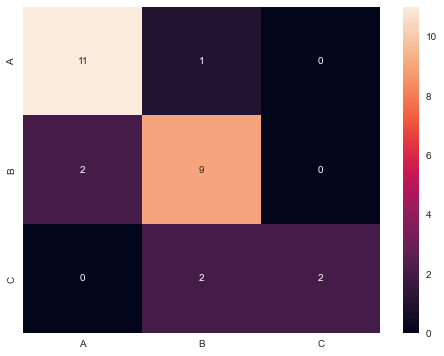

In [45]:
fit_and_print(MLP_best, X_test)

### KNN

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [56]:
KNN = KNeighborsClassifier()
cv = LeaveOneOut()

KNN_search_space = {
    'weights': Categorical(['uniform', 'distance']),  
    'n_neighbors': Integer(5, 8, 'uniform'), 
    'p': Integer(1, 3, 'uniform'), 
    'metric': Categorical(['minkowski']), 
    'leaf_size': Integer(30, 50, prior='uniform')}

In [57]:
KNN_bayes_search = BayesSearchCV(KNN, KNN_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 104, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
KNN_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(KNN_bayes_search.best_score_)
KNN_best = KNN_bayes_search.best_estimator_
print(KNN_bayes_search.best_estimator_)
print(KNN_bayes_search.best_params_)

time train
120.6719183921814
Acc
0.8952380952380953
KNeighborsClassifier(leaf_size=50, n_neighbors=6, p=1, weights='distance')
OrderedDict([('leaf_size', 50), ('metric', 'minkowski'), ('n_neighbors', 6), ('p', 1), ('weights', 'distance')])


<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

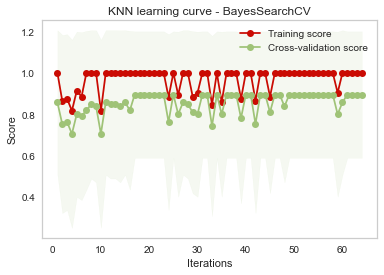

In [59]:
results_cv2 = pd.DataFrame(KNN_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "KNN learning curve - BayesSearchCV")

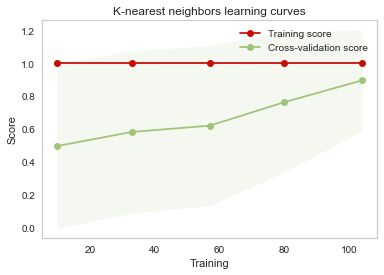

In [60]:
g = plot_learning_curve(KNN_best,"K-nearest neighbors learning curves", X_resampled, y_resampled,cv=cv)

In [61]:
filename_vot = './models/KNN_best_bayes_resampled.sav'
joblib.dump(KNN_best, filename_vot)

['./models/KNN_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.62      0.45      0.53        11
           2       0.50      0.50      0.50         4

    accuracy                           0.67        27
   macro avg       0.62      0.62      0.61        27
weighted avg       0.65      0.67      0.65        27

Gini:  [0.65       0.26704545 0.41304348]
ROC AUC::  [0.825      0.63352273 0.70652174]


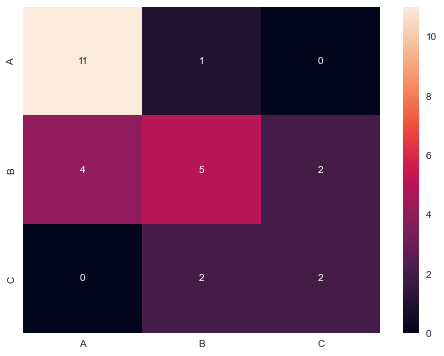

In [62]:
fit_and_print(KNN_best, X_test)

### Gaussian Process

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html

In [63]:
GP = GaussianProcessClassifier(random_state=30)
cv = LeaveOneOut()

GP_search_space  = {
        'optimizer' : Categorical(['fmin_l_bfgs_b']), 
        'n_restarts_optimizer': Integer(2, 6),
        'max_iter_predict': Integer(100, 130),
        'multi_class': Categorical(['one_vs_rest'])
         }

In [64]:
GP_bayes_search = BayesSearchCV(GP, GP_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 105, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
GP_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(GP_bayes_search.best_score_)
GP_best = GP_bayes_search.best_estimator_
print(GP_bayes_search.best_estimator_)
print(GP_bayes_search.best_params_)

time train
131.64440488815308
Acc
0.6761904761904762
GaussianProcessClassifier(max_iter_predict=125, n_restarts_optimizer=2,
                          random_state=30)
OrderedDict([('max_iter_predict', 125), ('multi_class', 'one_vs_rest'), ('n_restarts_optimizer', 2), ('optimizer', 'fmin_l_bfgs_b')])


<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

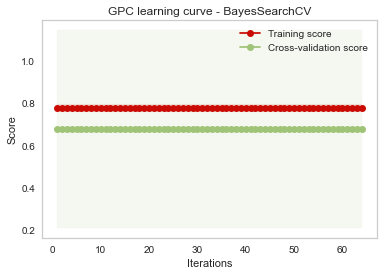

In [65]:
results_cv2 = pd.DataFrame(GP_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "GPC learning curve - BayesSearchCV")

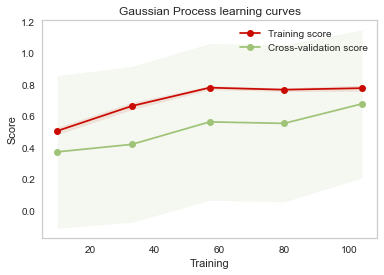

In [66]:
g = plot_learning_curve(GP_best,"Gaussian Process learning curves",X_resampled, y_resampled,cv=cv)

In [67]:
filename_vot = './models/GP_best_bayes_resampled.sav'
joblib.dump(GP_best, filename_vot)

['./models/GP_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       0.83      0.45      0.59        11
           2       0.60      0.75      0.67         4

    accuracy                           0.74        27
   macro avg       0.73      0.73      0.70        27
weighted avg       0.76      0.74      0.72        27

Gini:  [0.73333333 0.39204545 0.66304348]
ROC AUC::  [0.86666667 0.69602273 0.83152174]


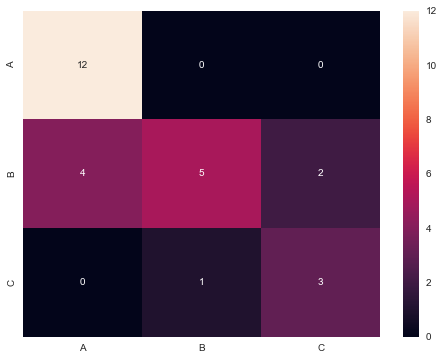

In [68]:
fit_and_print(GP_best, X_test)

### GBM

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [69]:
GBM = GradientBoostingClassifier(random_state=31)
cv = LeaveOneOut()
GBM_search_space = {

        'max_depth': Integer(4, 7, prior='uniform'),
        'loss': Categorical(['deviance']),
        'learning_rate' : Real(0.001, 0.05, prior='uniform') , 
        'n_estimators': Integer(20, 50, prior='uniform'),
        'criterion': Categorical(['friedman_mse', 'mse']),
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10, prior='uniform'),
        "min_samples_split": Integer(5, 20, prior='uniform')
    }

In [70]:
GBM_bayes_search = BayesSearchCV(GBM, GBM_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 106, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
GBM_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(GBM_bayes_search.best_score_)
GBM_best = GBM_bayes_search.best_estimator_
print(GBM_bayes_search.best_estimator_)
print(GBM_bayes_search.best_params_)

time train
485.55238008499146
Acc
0.9333333333333333
GradientBoostingClassifier(criterion='mse', learning_rate=0.03351431279534895,
                           loss='deviance', max_depth=5, max_features='sqrt',
                           min_samples_leaf=10, min_samples_split=5,
                           n_estimators=50, random_state=31)
OrderedDict([('criterion', 'mse'), ('learning_rate', 0.03351431279534895), ('loss', 'deviance'), ('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 10), ('min_samples_split', 5), ('n_estimators', 50)])


<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

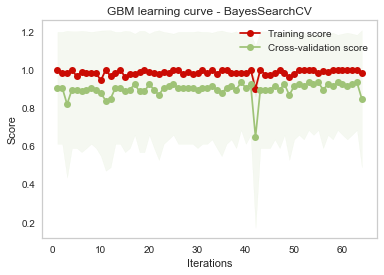

In [71]:
results_cv2 = pd.DataFrame(GBM_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "GBM learning curve - BayesSearchCV")

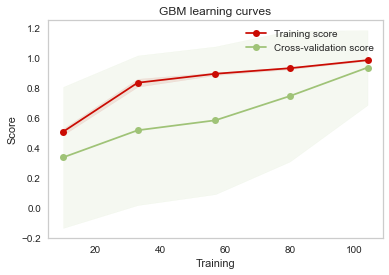

In [73]:
g = plot_learning_curve(GBM_best,"GBM learning curves",X_resampled, y_resampled,cv=cv)

In [74]:
filename_vot = './models/GBM_best_bayes_resampled.sav'
joblib.dump(GBM_best, filename_vot)

['./models/GBM_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.82      0.82      0.82        11
           2       0.50      0.50      0.50         4

    accuracy                           0.85        27
   macro avg       0.77      0.77      0.77        27
weighted avg       0.85      0.85      0.85        27

Gini:  [1.         0.69318182 0.41304348]
ROC AUC::  [1.         0.84659091 0.70652174]


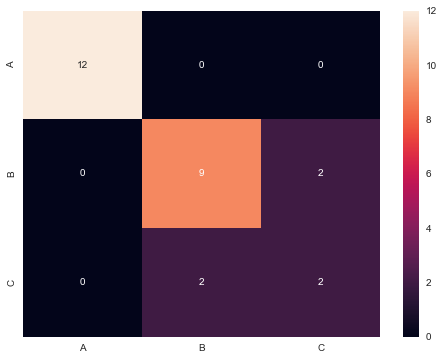

In [72]:
fit_and_print(GBM_best, X_test)

### LGBM

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [83]:
LGBM = LGBMClassifier(random_state=32)
cv = LeaveOneOut()
LGBM_search_space = {
        'num_iterations': Integer(40, 60, prior='uniform'),
        'learning_rate' : Real(0.001, 0.05, prior='uniform') , 
        'n_estimators': Integer(30, 50, prior='uniform'),
        'boosting_type': Categorical(['gbdt']),
        'objective': Categorical(['multiclass']),
        'num_class': [3],
        "num_leaves": Integer(5, 30, prior='uniform'),
        "max_depth": Integer(5, 7, prior='uniform'), 
        "min_child_samples": Integer(2, 10, prior='uniform'), 
        "reg_alpha": Real(0.001, 0.5, prior='uniform')
         }

In [84]:
LGBM_bayes_search = BayesSearchCV(LGBM, LGBM_search_space, n_iter=64, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 107, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
LGBM_bayes_search.fit(X_resampled, y_resampled) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(LGBM_bayes_search.best_score_)
LGBM_best = LGBM_bayes_search.best_estimator_
print(LGBM_bayes_search.best_estimator_)
print(LGBM_bayes_search.best_params_)

time train
187.21686673164368
Acc
0.9523809523809523
LGBMClassifier(learning_rate=0.046368560777321606, max_depth=5,
               min_child_samples=7, n_estimators=45, num_class=3,
               num_iterations=60, num_leaves=5, objective='multiclass',
               random_state=32, reg_alpha=0.22624190418493723)
OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.046368560777321606), ('max_depth', 5), ('min_child_samples', 7), ('n_estimators', 45), ('num_class', 3), ('num_iterations', 60), ('num_leaves', 5), ('objective', 'multiclass'), ('reg_alpha', 0.22624190418493723)])


<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\artigo\\lib\\site-packages\\matplotlib\\pyplot.py'>

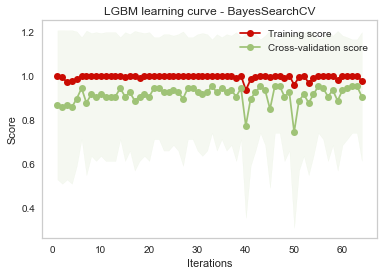

In [86]:
results_cv2 = pd.DataFrame(LGBM_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "LGBM learning curve - BayesSearchCV")

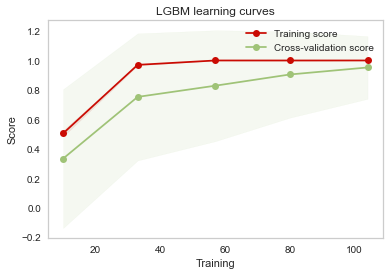

In [87]:
g = plot_learning_curve(LGBM_best,"LGBM learning curves",X_resampled, y_resampled,cv=cv)

In [88]:
filename_vot = './models/LGBM_best_bayes_resampled.sav'
joblib.dump(LGBM_best, filename_vot)

['./models/LGBM_best_bayes_resampled.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.80      0.73      0.76        11
           2       0.50      0.50      0.50         4

    accuracy                           0.81        27
   macro avg       0.74      0.74      0.74        27
weighted avg       0.81      0.81      0.81        27

Gini:  [0.93333333 0.60227273 0.41304348]
ROC AUC::  [0.96666667 0.80113636 0.70652174]


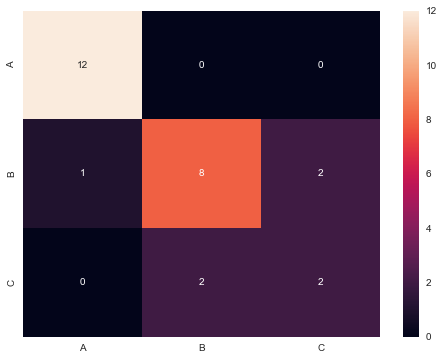

In [85]:
fit_and_print(LGBM_best, X_test)